# Testing Simulation 

In this notebook I will test if it makes a diffference if the simulation simulates the bond uisng 
1. the sequence (1,2,3), (2,3,4), (3,4,5)... or
2. the sequence (1,2,3), (2,3,4), (4,5,6)

In [7]:
#import general packages
import numpy as np
from colorama import Fore, Style, Back

%load_ext autoreload
%autoreload 2
import exposures as ex
import impact as cimp
import bound_prot_dam as bpd
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd

In [9]:
import pandas as pd
import random
import matplotlib.pyplot as plt

import functions as fct


term = 3
simulated_years = 10001

def init_bond_exp_loss(events_per_year, nominal):
    losses = []
    cur_nominal = nominal
    payout_count = 0

    for k in range(term):
        #randomly generate number of events in one year using poisson distribution and calculated yearly event probability
        payouts = np.sum(events_per_year[k]['pay'].to_numpy())
        #If there are events in the year, sample that many payouts and the associated damages
        if payouts == 0 or cur_nominal == 0:
            sum_payouts = 0
        elif payouts > 0:
            sum_payouts = payouts 
            cur_nominal -= sum_payouts
            payout_count += 1
            if cur_nominal < 0:
                sum_payouts += cur_nominal
                cur_nominal = 0
            else:
                pass

        losses.append(sum_payouts)
    att_prob = payout_count / term
    tot_loss = np.sum(losses) /nominal
    rel_losses = np.array(losses) / nominal
    return rel_losses, att_prob, tot_loss



def init_exp_loss_att_prob_simulation(pay_dam_df, nominal, print_prob=True):
    att_prob_list = []
    annual_losses = []
    total_losses = []
    for i in range(0, simulated_years-term, 3):
        events_per_year = []
        for j in range(term):
            if 'year' in pay_dam_df.columns:
                events_per_year.append(pay_dam_df[pay_dam_df['year'] == (i+j)])
            else:
                events_per_year.append(pd.DataFrame({'pay': [0], 'damage': [0]}))
        losses, att_prob, tot_loss = init_bond_exp_loss(events_per_year, nominal)

        att_prob_list.append(att_prob)
        annual_losses.extend(losses)
        total_losses.append(tot_loss)

    att_prob = np.mean(att_prob_list)
    exp_loss_ann = np.mean(annual_losses)

    annual_losses = pd.Series(annual_losses)
    total_losses = pd.Series(total_losses)

    VaR_99_ann = annual_losses.quantile(0.99)
    VaR_99_tot = total_losses.quantile(0.99)
    VaR_95_ann = annual_losses.quantile(0.95)
    VaR_95_tot = total_losses.quantile(0.95)
    if VaR_99_ann == 1:
        ES_99_ann = 1
    else:
        ES_99_ann = annual_losses[annual_losses > VaR_99_ann].mean()
    if VaR_99_tot == 1:
        ES_99_tot = 1
    else:
        ES_99_tot = total_losses[total_losses > VaR_99_tot].mean()
    if VaR_95_ann == 1:
        ES_95_ann = 1
    else:
        ES_95_ann = annual_losses[annual_losses > VaR_95_ann].mean()
    if VaR_95_tot == 1:
        ES_95_tot = 1
    else:
        ES_95_tot = total_losses[total_losses > VaR_95_tot].mean()
    es_metrics = {'VaR_99_ann': VaR_99_ann, 'VaR_99_tot': VaR_99_tot, 'VaR_95_ann': VaR_95_ann, 'VaR_95_tot': VaR_95_tot,
                  'ES_99_ann': ES_99_ann, 'ES_99_tot': ES_99_tot, 'ES_95_ann': ES_95_ann, 'ES_95_tot': ES_95_tot}

    if print_prob:
        print(f'Expected Loss = {exp_loss_ann}')
        print(f'Attachment Probability = {att_prob}')

    return exp_loss_ann, att_prob, annual_losses, es_metrics

def init_bond_simulation(pay_dam_df, premiums, rf_rate, nominal, want_ann_returns=True, model_rf=False):

    metric_names = ['tot_payout', 'tot_damage', 'tot_pay']

    #Check if premiums/rf_rates are single values
    premiums = fct.check_scalar(premiums)

    metrics_per_premium = pd.DataFrame(index = range(len(premiums)), columns=["Premium", "Sharpe_ratio_ann", "Sharpe_ratio_tot",
                                                                              "Coverage", "Basis_risk", "Average Payments"])

    returns_per_premium = pd.DataFrame(index = range(len(premiums)), columns=["Premium","Annual", "Total"])

    for z, premium in enumerate(premiums):
        #Monte Carlo Simulation
        annual_returns = []
        tot_returns = []
        rf_annual = []
        rf_total = []
        metrics_sim = {key: [] for key in metric_names}
        for i in range(0, simulated_years-term, 3):
            #model interest rates if wanted
            if model_rf:
                rf = sb.init_model_rf(rf_rate)
            else:
                rf = rf_rate
            #create events per year of bond term
            events_per_year = []
            for j in range(term):
                if 'year' in pay_dam_df.columns:
                    events_per_year.append(pay_dam_df[pay_dam_df['year'] == (i+j)])
                else:
                    events_per_year.append(pd.DataFrame({'pay': [0], 'damage': [0]}))
            simulated_ncf_rel, metrics, rf_rates_list = init_bond(events_per_year, premium, rf, nominal)
    
            metrics_sim['tot_payout'].append(metrics['tot_payout'])
            metrics_sim['tot_damage'].append(metrics['tot_damage'])
            metrics_sim['tot_pay'].append(metrics['tot_pay'])

            if want_ann_returns:
                annual_returns.extend(simulated_ncf_rel)
            else:
                ann_return = (1 + sum(simulated_ncf_rel)) ** (1/term) - 1
                annual_returns.append(ann_return)

            tot_returns.append(np.sum(simulated_ncf_rel))
            rf_annual.append(np.mean(rf_rates_list))
            rf_total.append(np.sum(rf_rates_list))

        # Convert simulated net cash flows to a series
        annual_returns = pd.Series(annual_returns)
        tot_returns = pd.Series(tot_returns)
        #calculate finacial metrics
        metrics_sim_sum = {}
        metrics_sim_sum['tot_payout'] = np.sum(metrics_sim['tot_payout'])
        metrics_sim_sum['tot_damage'] = np.sum(metrics_sim['tot_damage'])
        metrics_sim_sum['tot_pay'] = np.nanmean(metrics_sim['tot_pay'])
        premium_float = np.float64(premium)

        sharpe_ratio_ann = sb.init_sharpe_ratio(annual_returns, rf_annual)
        sharpe_ratio_tot = sb.init_sharpe_ratio(tot_returns, rf_total)

        metrics_per_premium.loc[z] = [premium_float, sharpe_ratio_ann, sharpe_ratio_tot,
                                      metrics_sim_sum['tot_payout']/metrics_sim_sum['tot_damage'], metrics_sim_sum['tot_payout']-metrics_sim_sum['tot_damage'], metrics_sim_sum['tot_pay']]  
        
        returns_per_premium.loc[z] = [premium_float, annual_returns, tot_returns]

    return metrics_per_premium, returns_per_premium

def init_bond(events_per_year, premium, risk_free_rates, nominal):
    simulated_ncf = []
    tot_payout = []
    tot_damage = []
    rf_rates_list = []
    metrics = {}    
    cur_nominal = nominal

    for k in range(term):
        rf = sb.check_rf(risk_free_rates, k)
        rf_rates_list.append(rf)
        payouts = np.sum(events_per_year[k]['pay'].to_numpy()) 
        damages = np.sum(events_per_year[k]['damage'].to_numpy())            
        #If there are events in the year, sample that many payouts and the associated damages
        sum_damages = damages
        if payouts == 0:
            sum_payouts = 0
        elif payouts > 0:
            sum_payouts = payouts
            cur_nominal -= sum_payouts
            if cur_nominal < 0:
                sum_payouts += cur_nominal
                cur_nominal = 0
            else:
                pass

        net_cash_flow = (cur_nominal * (premium + rf)) - sum_payouts
            

        simulated_ncf.append(net_cash_flow)
        tot_payout.append(sum_payouts)
        tot_damage.append(sum_damages)
    simulated_ncf_rel = np.array(simulated_ncf) / nominal
    metrics['tot_payout'] = np.sum(tot_payout)
    metrics['tot_damage'] = np.sum(tot_damage)
    if np.sum(tot_payout) == 0:
        tot_pay = np.nan
    else:
        tot_pay = np.sum(tot_payout)
    metrics['tot_pay'] = tot_pay

    return simulated_ncf_rel, metrics, rf_rates_list

In [10]:
def alt_sng_cty_bond(country, prot_share, rf_rate, target_sharpe, grid_size=600, buffer_size=1, low_to_prot=None, to_prot_share=None, incl_plots=False):    
    #load tc_tracks, create hazard class and calculate exposure
    exp, applicable_basin, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country=country, grid_size=grid_size, buffer_size=buffer_size, load_fls=True, plot_exp=incl_plots, plot_centrs=incl_plots, plt_grd=incl_plots)
    #calculate impact and aggregate impact per grid
    imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf, plot_frequ=incl_plots) 
    if low_to_prot is not None: 
            imp_per_event_flt, imp_admin_evt_flt, imp_lower_rp = bpd.init_imp_flt(imp_per_event, imp_admin_evt, lower_rp=low_to_prot)
    else:
        imp_per_event_flt, imp_admin_evt_flt, imp_lower_rp = bpd.init_imp_flt(imp_per_event, imp_admin_evt, prot_share=to_prot_share, exposure=exp)
    #set up hazard intensity matrix per grid and event
    int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat='mean')

    premium_dic = {'ibrd': 0, 'regression': 0, 'required': 0, 'exp_loss': 0, 'att_prob': 0}


    nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=prot_share)
    if nominal < imp_lower_rp:
        print(Back.RED + "Warning: Given Budget to small to cover specified minimal damage")
        print("The specified damage which should be covered is: ",round(imp_lower_rp, 3), " [USD]")
        print(Style.RESET_ALL)
    #optimize minimum and maximum triggering wind speed per grid cell
    result, optimized_1, optimized_2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt, print_params=incl_plots)
    #create data frame containing payment vs damage per event
    pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_1, optimized_2, int_grid, nominal, imp_admin_evt)
    #calculate expected loss and attachment probability
    exp_loss_ann, att_prob, ann_losses, es_metrics = init_exp_loss_att_prob_simulation(pay_dam_df, nominal, print_prob=False)
    #calculate premiums using different approaches
    requ_prem = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)
    ibrd_prem = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
    premium_dic['regression'] = cp.calc_premium_regression(exp_loss_ann *100)/100
    premium_dic['required'] = requ_prem
    premium_dic['ibrd'] = ibrd_prem
    #simulate cat bond
    premium_simulation, returns = init_bond_simulation(pay_dam_df, ibrd_prem, rf_rate, nominal) 
    premium_dic['exp_loss'] = exp_loss_ann
    premium_dic['att_prob'] = att_prob

    return premium_simulation, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt

In [11]:
#define minimum return period to be covered
lower_rp = 25

#define maximum return period to be covered
upper_rp = 50

#define benchmark sharpe ratio
target_sharpe = 0.25

#define the risk free rate
rf_rate = 0.05

In [12]:
print(Back.RED + "St. Kitts and Nevis")
bond_metrics_kitt, returns_kitt, premium_dic_kitt, nominal_kitt, pay_dam_df_kitt, es_metrics_kitt, int_grid_kitt, imp_per_event_flt_kitt, imp_admin_evt_flt_kitt = bond_fct.sng_cty_bond(country=659, 
                                                                                                                                                                                         prot_share=upper_rp, 
                                                                                                                                                                                         rf_rate=rf_rate, 
                                                                                                                                                                                         target_sharpe=target_sharpe, 
                                                                                                                                                                                         low_to_prot=lower_rp)

print(Back.RED + "Comoros")
bond_metrics_com, returns_com, premium_dic_com, nominal_com, pay_dam_df_com, es_metrics_com, int_grid_com, imp_per_event_flt_com, imp_admin_evt_flt_com = bond_fct.sng_cty_bond(country=174, 
                                                                                                                                                                                prot_share=250, 
                                                                                                                                                                                rf_rate=rf_rate, 
                                                                                                                                                                                target_sharpe=target_sharpe, 
                                                                                                                                                                                low_to_prot=100)

print(Back.RED + "Grenada")
bond_metrics_gren, returns_gren, premium_dic_gren, nominal_gren, pay_dam_df_gren, es_metrics_gren, int_grid_gren, imp_per_event_flt_gren, imp_admin_evt_flt_gren = bond_fct.sng_cty_bond(country=308, 
                                                                                                                                                                                         prot_share=upper_rp, 
                                                                                                                                                                                         rf_rate=rf_rate, 
                                                                                                                                                                                         target_sharpe=target_sharpe, 
                                                                                                                                                                                         low_to_prot=lower_rp)

St. Kitts and Nevis
Number of tracks in NA basin: 946
The principal of the cat bond is: 80453906.699 [USD]
Principal as share of GDP: 0.091
Comoros
Number of tracks in SI basin: 229
The principal of the cat bond is: 116444517.304 [USD]
Principal as share of GDP: 0.095
Grenada
Number of tracks in NA basin: 2692
The principal of the cat bond is: 104716116.948 [USD]
Principal as share of GDP: 0.1


In [13]:
print(Back.RED + "St. Kitts and Nevis")
bond_metrics_kitt_alt, returns_kitt_alt, premium_dic_kitt_alt, nominal_kitt_alt, pay_dam_df_kitt_alt, es_metrics_kitt_alt, int_grid_kitt_alt, imp_per_event_flt_kitt_alt, imp_admin_evt_flt_kitt_alt = alt_sng_cty_bond(country=659, 
                                                                                                                                                                                                                        prot_share=upper_rp, 
                                                                                                                                                                                                                        rf_rate=rf_rate, 
                                                                                                                                                                                                                        target_sharpe=target_sharpe, 
                                                                                                                                                                                                                        low_to_prot=lower_rp)

print(Back.RED + "Comoros")
bond_metrics_com_alt, returns_com_alt, premium_dic_com_alt, nominal_com_alt, pay_dam_df_com_alt, es_metrics_com_alt, int_grid_com_alt, imp_per_event_flt_com_alt, imp_admin_evt_flt_com_alt = alt_sng_cty_bond(country=174, 
                                                                                                                                                                                                               prot_share=250, 
                                                                                                                                                                                                               rf_rate=rf_rate, 
                                                                                                                                                                                                               target_sharpe=target_sharpe, 
                                                                                                                                                                                                               low_to_prot=100)

print(Back.RED + "Grenada")
bond_metrics_gren_alt, returns_gren_alt, premium_dic_gren_alt, nominal_gren_alt, pay_dam_df_gren_alt, es_metrics_gren_alt, int_grid_gren_alt, imp_per_event_flt_gren_alt, imp_admin_evt_flt_gren_alt = alt_sng_cty_bond(country=308, 
                                                                                                                                                                                                                        prot_share=upper_rp, 
                                                                                                                                                                                                                        rf_rate=rf_rate, 
                                                                                                                                                                                                                        target_sharpe=target_sharpe, 
                                                                                                                                                                                                                        low_to_prot=lower_rp)

St. Kitts and Nevis
Number of tracks in NA basin: 946
The principal of the cat bond is: 80453906.699 [USD]
Principal as share of GDP: 0.091
Comoros
Number of tracks in SI basin: 229
The principal of the cat bond is: 116444517.304 [USD]
Principal as share of GDP: 0.095
Grenada
Number of tracks in NA basin: 2692
The principal of the cat bond is: 104716116.948 [USD]
Principal as share of GDP: 0.1


In [14]:
#print relevant metrics for both single country bonds
print(Back.RED + "St. Kitts and Nevis")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_kitt, 
                           returns=returns_kitt, 
                           premium_dic=premium_dic_kitt, 
                           nominal=nominal_kitt)
print(Style.RESET_ALL)
print(Back.RED + "Comoros")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_com, 
                           returns=returns_com, 
                           premium_dic=premium_dic_com, 
                           nominal=nominal_com)
print(Style.RESET_ALL)
print(Back.RED + "Grenada")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_gren, 
                           returns=returns_gren, 
                           premium_dic=premium_dic_gren, 
                           nominal=nominal_gren)

St. Kitts and Nevis

Expected Loss: 2.9 %
Attachment Probability: 3.4 %
Coverage: 52.5 %
Premium Ibrd: 6.2 %; 4987690.0 USD
Premium Chatoro et al. 8.3 %; 6661510.0 USD
Premium Target Sharpe Ratio 8.1 %; 6516761.0 USD
Standard Deviation of Returns 0.18

Comoros

Expected Loss: 0.6 %
Attachment Probability: 0.7 %
Coverage: 43.2 %
Premium Ibrd: 2.5 %; 2854897.0 USD
Premium Chatoro et al. 5.1 %; 5912339.0 USD
Premium Target Sharpe Ratio 2.6 %; 2979918.0 USD
Standard Deviation of Returns 0.08

Grenada

Expected Loss: 3.2 %
Attachment Probability: 4.0 %
Coverage: 56.2 %
Premium Ibrd: 6.6 %; 6862455.0 USD
Premium Chatoro et al. 8.8 %; 9197594.0 USD
Premium Target Sharpe Ratio 8.8 %; 9237516.0 USD
Standard Deviation of Returns 0.18


In [15]:
#print relevant metrics for both single country bonds
print(Back.RED + "St. Kitts and Nevis - Alt")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_kitt_alt, 
                           returns=returns_kitt_alt, 
                           premium_dic=premium_dic_kitt_alt, 
                           nominal=nominal_kitt_alt)
print(Style.RESET_ALL)
print(Back.RED + "Comoros - Alt")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_com_alt, 
                           returns=returns_com_alt, 
                           premium_dic=premium_dic_com_alt, 
                           nominal=nominal_com_alt)
print(Style.RESET_ALL)
print(Back.RED + "Grenada - Alt")
print(Style.RESET_ALL)
fct.print_sng_bnd_rel_metr(bond_metrics=bond_metrics_gren_alt, 
                           returns=returns_gren_alt, 
                           premium_dic=premium_dic_gren_alt, 
                           nominal=nominal_gren_alt)

St. Kitts and Nevis - Alt

Expected Loss: 2.9 %
Attachment Probability: 3.4 %
Coverage: 52.6 %
Premium Ibrd: 6.2 %; 4991813.0 USD
Premium Chatoro et al. 8.3 %; 6667342.0 USD
Premium Target Sharpe Ratio 8.1 %; 6500715.0 USD
Standard Deviation of Returns 0.18

Comoros - Alt

Expected Loss: 0.6 %
Attachment Probability: 0.7 %
Coverage: 43.2 %
Premium Ibrd: 2.5 %; 2854679.0 USD
Premium Chatoro et al. 5.1 %; 5912247.0 USD
Premium Target Sharpe Ratio 2.6 %; 2980608.0 USD
Standard Deviation of Returns 0.08

Grenada - Alt

Expected Loss: 3.2 %
Attachment Probability: 4.0 %
Coverage: 55.9 %
Premium Ibrd: 6.5 %; 6847578.0 USD
Premium Chatoro et al. 8.8 %; 9176424.0 USD
Premium Target Sharpe Ratio 8.8 %; 9202997.0 USD
Standard Deviation of Returns 0.18


In [16]:
bond_metrics_gren_alt = {}
premium_dic_gren_alt = {}
es_metrics_gren_alt = {}

bond_metrics_gren = {}
premium_dic_gren = {}
es_metrics_gren = {}

for i in range(20):

    bond_metrics_gren[i], returns_gren, premium_dic_gren[i], nominal_gren, pay_dam_df_gren, es_metrics_gren[i], int_grid_gren, imp_per_event_flt_gren, imp_admin_evt_flt_gren = bond_fct.sng_cty_bond(country=308, 
                                                                                                                                                                                             prot_share=upper_rp, 
                                                                                                                                                                                             rf_rate=rf_rate, 
                                                                                                                                                                                             target_sharpe=target_sharpe, 
                                                                                                                                                                                             low_to_prot=lower_rp)

    bond_metrics_gren_alt[i], returns_gren_alt, premium_dic_gren_alt[i], nominal_gren_alt, pay_dam_df_gren_alt, es_metrics_gren_alt[i], int_grid_gren_alt, imp_per_event_flt_gren_alt, imp_admin_evt_flt_gren_alt = alt_sng_cty_bond(country=308, 
                                                                                                                                                                                                                                     prot_share=upper_rp, 
                                                                                                                                                                                                                                     rf_rate=rf_rate, 
                                                                                                                                                                                                                                     target_sharpe=target_sharpe, 
                                                                                                                                                                                                                                     low_to_prot=lower_rp)
    upper_rp +=20

upper_rp = 50


Number of tracks in NA basin: 2692
The principal of the cat bond is: 104716116.948 [USD]
Principal as share of GDP: 0.1
Number of tracks in NA basin: 2692
The principal of the cat bond is: 104716116.948 [USD]
Principal as share of GDP: 0.1
Number of tracks in NA basin: 2692
The principal of the cat bond is: 148649569.461 [USD]
Principal as share of GDP: 0.142
Number of tracks in NA basin: 2692
The principal of the cat bond is: 148649569.461 [USD]
Principal as share of GDP: 0.142
Number of tracks in NA basin: 2692
The principal of the cat bond is: 183226775.798 [USD]
Principal as share of GDP: 0.176
Number of tracks in NA basin: 2692
The principal of the cat bond is: 183226775.798 [USD]
Principal as share of GDP: 0.176
Number of tracks in NA basin: 2692
The principal of the cat bond is: 202223274.207 [USD]
Principal as share of GDP: 0.194
Number of tracks in NA basin: 2692
The principal of the cat bond is: 202223274.207 [USD]
Principal as share of GDP: 0.194
Number of tracks in NA basin

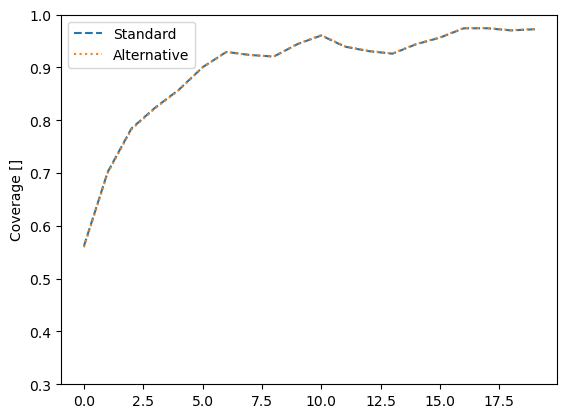

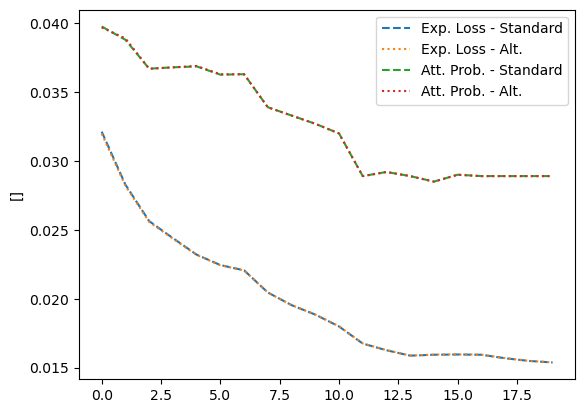

In [28]:
import functions as fct
x_array = np.arange(0,20,1)
coverage_nom = []
coverage_nom_alt = []
exp_loss = []
exp_loss_alt = []
att_prob = []
att_prob_alt = []

for i in range(20):
    coverage_nom.append(bond_metrics_gren[i]['Coverage'])
    coverage_nom_alt.append(bond_metrics_gren_alt[i]['Coverage'])
    exp_loss.append(premium_dic_gren[i]['exp_loss'])
    exp_loss_alt.append(premium_dic_gren_alt[i]['exp_loss'])
    att_prob.append(premium_dic_gren[i]['att_prob'])
    att_prob_alt.append(premium_dic_gren_alt[i]['att_prob'])


plt.plot(x_array, coverage_nom, linestyle='dashed', label='Standard')
plt.plot(x_array, coverage_nom_alt, linestyle='dotted', label='Alternative')
plt.xlabel('')
plt.ylabel('Coverage []')
plt.ylim(0.3,1)
plt.legend()
plt.show()


plt.plot(x_array, exp_loss, linestyle='dashed', label='Exp. Loss - Standard')
plt.plot(x_array, exp_loss_alt, linestyle='dotted', label='Exp. Loss - Alt.')
plt.plot(x_array, att_prob, linestyle='dashed', label='Att. Prob. - Standard')
plt.plot(x_array, att_prob_alt, linestyle='dotted', label='Att. Prob. - Alt.')
plt.xlabel('')
plt.ylabel('[]')
plt.legend()
plt.show()